### The scope of this tutorial

In this tutorial, you will learn the basics of the analysis of Mass Spectrometry Imaging data in Python 3 using pyimzml and masserstein packages.  
The tutorial starts with the visualization of spectra and generating ion images based on profile spectra.  
Next, we show how to resample profile spectra and generate summary spectra for images.  
We then proceed with centroiding of profile spectra and generating ion images from centroided data.  
We show how to perform a Principal Component Analysis on centroided peak intensities.  
The tutorial finishes with regression of mass spectra using masserstein.  

### Requirements

Required Python3 packages:
    - matplotlib
    - numpy
    - pyimzml
    - scikit-learn
    - masserstein, downloadable at https://github.com/mciach/masserstein

The mass spectrometric image used in this tutorial is available here: https://www.ebi.ac.uk/metabolights/MTBLS487 (test_POS.ibd and  test_POS.imzML)

The command below will make all plots in this notebook interactive (so that we can e.g. interactively zoom in different regions, and inspect coordinates of points by hovering the cursor above them):

In [1]:
%matplotlib notebook

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['figure.max_open_warning']=30

### Basic operations

Loading images:

In [3]:
from pyimzml.ImzMLParser import ImzMLParser
image = ImzMLParser('test_POS.imzML')

Selecting a spectrum at a given coordinate. In pyimzml image, each pixel has three coordinates: X, Y, and Z. Since we're dealing with 2D images, the Z coordinate is always equal to 1.  

In [4]:
X,Y = 40, 20
spectrum_id = image.coordinates.index((X, Y, 1))
mz, intensity = image.getspectrum(spectrum_id)

Generating a masserstein.Spectrum object:

In [5]:
from masserstein import Spectrum
S = Spectrum(confs = list(zip(mz, intensity)))

Plotting the spectrum.  
When using the `%matplotlib notebook` option, we need to call `plt.figure()` before a new plot.  
Otherwise the new plot will be shown in the last active plot window.  

<IPython.core.display.Javascript object>


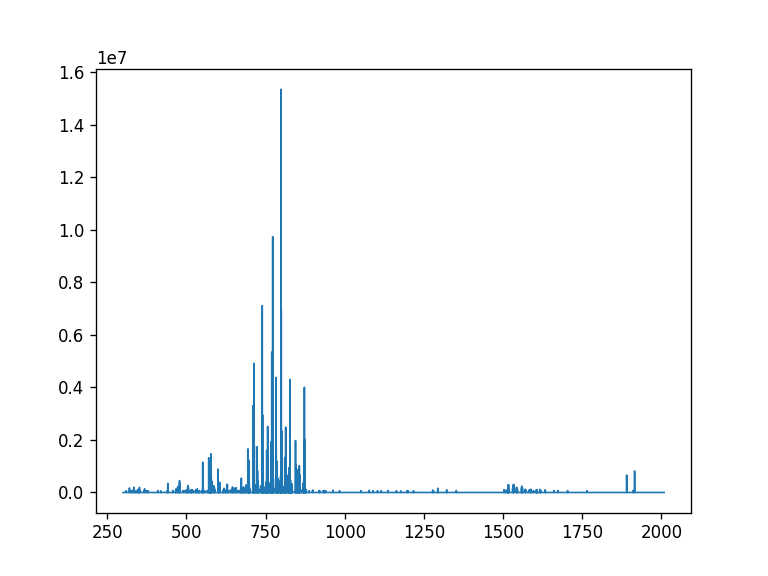

In [6]:
plt.figure()
S.plot(profile=True)

Plotting a fragment of the spectrum.  
This requires to use the keyword argument `show=False` in `Spectrum.plot()` method, because otherwise this method creates a new figure and resets the plot settings.  

<IPython.core.display.Javascript object>


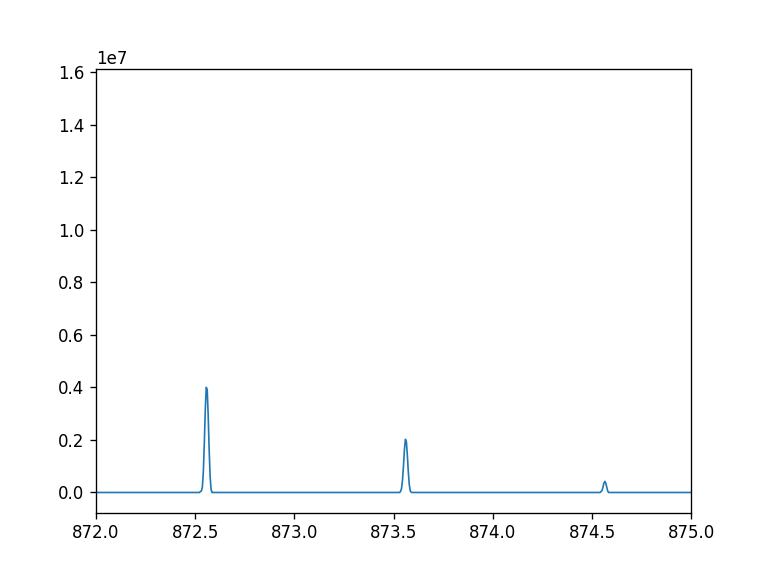

In [7]:
plt.figure()
plt.xlim(872.0, 875.0)
S.plot(profile=True, show=False)

Computing the total ion current (i.e. the sum of signal intensities) in each pixel.  
We will use the `numpy.trapz()` function to integrate the signals. Its documentation can be shown in Jupyter Notebook by typing `?numpy.trapz`. 

In [8]:
import numpy as np

In [9]:
TIC_array = []  # list to store pixel total ion currents
coords = []  # list to store pixel coordinates
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    coords.append((xcoord,ycoord))
    mz,intsy =  image.getspectrum(idx)
    tic = np.trapz(intsy, mz)  # numerical integration
    TIC_array.append(tic)

In [10]:
coords = np.array(coords)
TIC_array = np.array(TIC_array)

Generating the total ion current image - option 1: use `plt.scatter()` and supply it with pixel coordinates

In [11]:
from matplotlib import cm  # color palettes

<IPython.core.display.Javascript object>


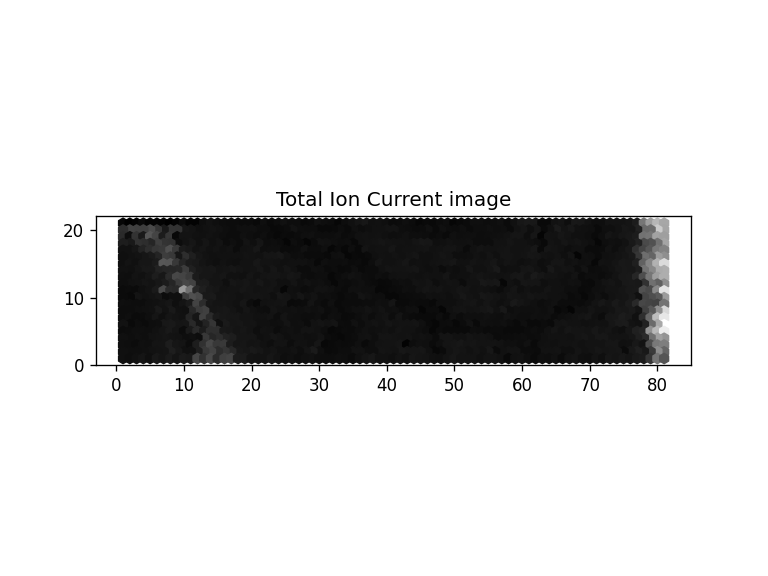

In [12]:
plt.figure()
plt.title('Total Ion Current image')
plt.scatter(coords[:,0], coords[:,1], c=TIC_array, marker='h', cmap=cm.gray)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Generating the total ion current image - option 2: store the ion currents in a matrix of the same dimentions as the image and use `plt.imshow()` to visualize it.  
We will invert the y axis by writing `-crd[1]` when indexing the `TIC_matrix` variable below. We do it this way because `plt.imshow()` uses matrix coordinates, i.e. by default the point (0, 0) is in the upper-left corner of the image, because it corresponds to the first row and first column of the matrix.  

In [13]:
TIC_matrix = np.zeros((21, 81))
for crd, tic in zip(coords, TIC_array):
        crd = crd-1
        TIC_matrix[-crd[1], crd[0]] = tic

Calling `plt.show()` in the cell below will suppress additional messages written by matplotlib under the image, making the notebook look nicer. 

<IPython.core.display.Javascript object>


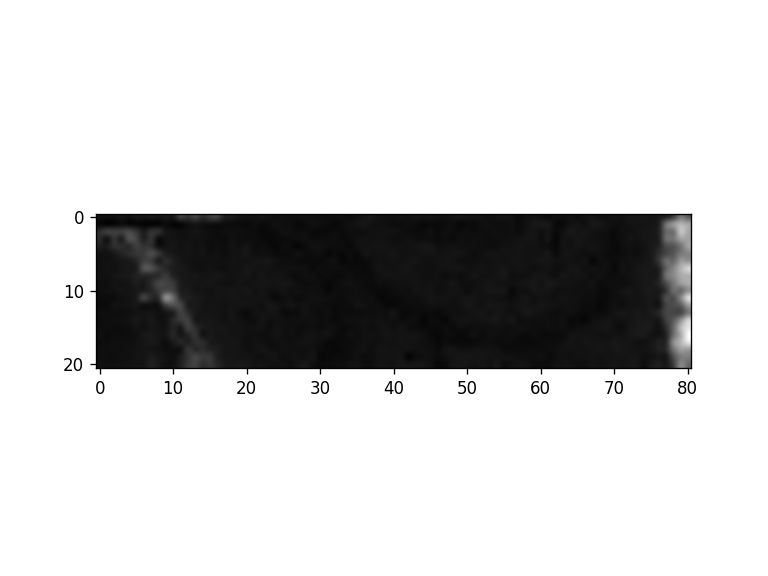

In [14]:
plt.figure()
plt.imshow(TIC_matrix, cmap=cm.gray, interpolation='mitchell')
plt.show()  

Plotting a single ion image, i.e. the intensity of a single peak. We'll visualize the intensity of the peak at mz = 872.5 Da, shown on one of the spectra plotted above. The integration boundaries can be selected by using the interactive plot window, hovering the cursor above peak boundaries, and inspecting the coordinates shown in the lower-right corner of the plot.    

In [15]:
image_872_5 = np.zeros((21, 81))
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    mz,intsy =  image.getspectrum(idx)
    mz = np.array(mz)
    intsy = np.array(intsy)
    
    in_region = (872.49 <= mz) & (mz <= 872.62)
    mz = mz[in_region]
    intsy = intsy[in_region]
    
    signal = np.trapz(intsy, mz)  # numerical integration
    image_872_5[-(ycoord - 1), xcoord - 1] = signal

<IPython.core.display.Javascript object>


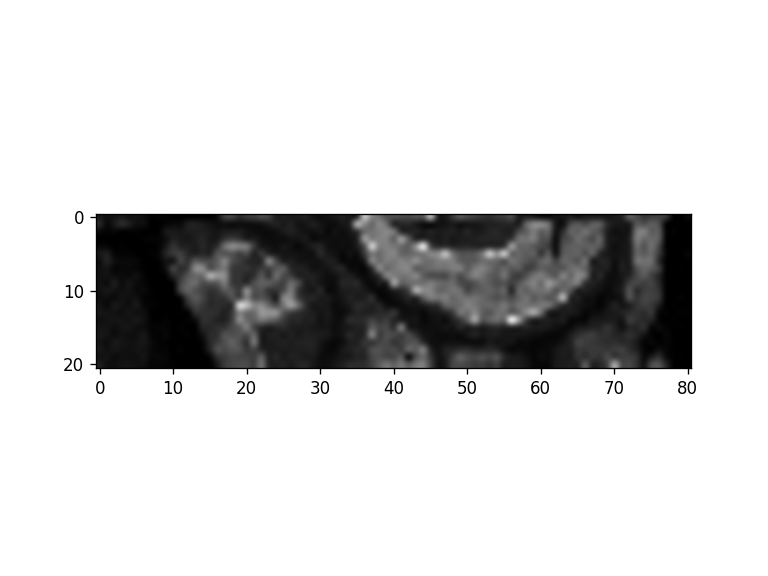

In [16]:
plt.figure()
plt.imshow(image_872_5, cmap=cm.gray, interpolation='mitchell')
plt.show()

**Exercise:** Generate an ion image for the peak at 798.55 Da using both methods of generating images (with `plt.scatter()` and `plt.imshow()`).  

### Resampling spectra
This means taking our arrays of mz and intensity measurements and approximating the intensities at new mz values. For a visual explanation of this procedure, see Figure 5 of the Supplementary Information to the Masserstein paper, available here:  
https://onlinelibrary.wiley.com/doi/abs/10.1002/rcm.8956

In [17]:
def resample(x, mz, intsy, threshold=0.05):
    """
    Returns intensity values at points given by x (a sorted iterable),
    by piecewise linear interpolation of a target spectrum in profile mode
    given by vectors of mass and intensity values (mz and intsy). 
    The spectrum is interpolated only if two target mz values closest to a 
    given point from x are closer than the specified threshold (in order to interpolate only within peaks),
    otherwise it's assumed that there is no intensity at a given point.
    A rule-of-thumb is to set threshold as twice the distance between neighboring m/z measurements.
    Larger thresholds decrease computational efficiency, lower ones might cause bad interpolation.
    """
    assert len(mz) == len(intsy)
    lenx = len(x)
    lent = len(mz)
    qi = 0  # query (x) index
    ti = 0  # target index - the first index s.t. mz[ti] >= x[qi]
    y = [0.]*lenx
    y0, y1 = intsy[0], intsy[0]  # intensities of target spectrum around the point x[qi]
    x0, x1 = mz[0], mz[0]  # mz around the point x[qi]
    # before mz starts, the intensity is zero:
    while x[qi] < mz[0]:
        qi += 1
    # interpolating:
    while ti < lent-1:
        ti += 1
        y0 = y1
        y1 = intsy[ti]
        x0 = x1
        x1 = mz[ti]
        while qi < lenx and x[qi] <= mz[ti]:
            if x1-x0 < threshold:  # note: maybe in this case set one of the values to zero to get a better interpolation of edges
                y[qi] = y1 + (x[qi]-x1)*(y0-y1)/(x0-x1)
            qi += 1
    return y 

Resampling a single spectrum at given pixel coordinates:

In [18]:
X,Y = 40, 20
spectrum_id = image.coordinates.index((X, Y, 1))
mz, intensity = image.getspectrum(spectrum_id)
mz = np.array(mz)
intensity = np.array(intensity)

In [19]:
in_region = (872.2 <= mz) & (mz <= 876)
mz = mz[in_region]
intensity = intensity[in_region]

In [20]:
new_mz = np.linspace(872, 876, 400)
new_intensity = resample(new_mz, mz, intensity)

Comparison of original and resampled spectrum. Red dots indicate measurement points, i.e. pairs of corresponding mz and intensity values that represent the spectrum.

<IPython.core.display.Javascript object>


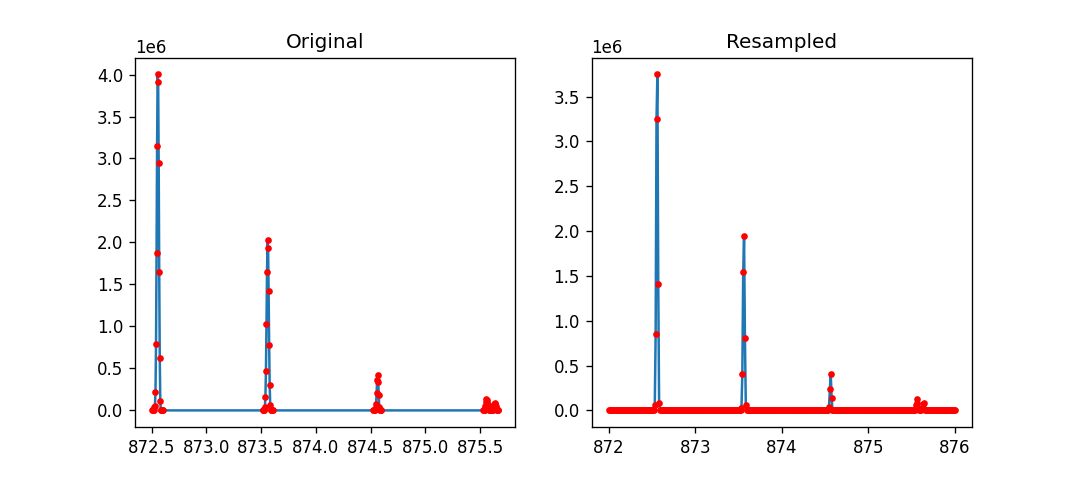

Text(0.5, 1.0, 'Resampled')

In [21]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.plot(mz, intensity)
plt.plot(mz, intensity, 'r.')
plt.title('Original')
plt.subplot(122)
plt.plot(new_mz, new_intensity)
plt.plot(new_mz, new_intensity, 'r.')
plt.title('Resampled')

### Computing a summary spectrum
A summary spectrum for a mass spectrometry image is a plot containing an average spectrum with the standard deviation of intensity at each point and with the maximum and minimum intensity. For an example of a summary spectrum, see Figure 6 of the main body of the Masserstein paper. 

To obtain an average intensity, we need to resample the spectra so that the mz measurements agree for all pixels. First, we create a reference mz array.   
In many mass spectra the peaks get broader as the mass increases. Because of this, we usually don't want to have a constant spacing between two consecutive mz points in our mz array (we want approximately constant number of measurements for each peak).  
To check the appropriate distance between two points, we look at the ends of a spectrum:

<IPython.core.display.Javascript object>


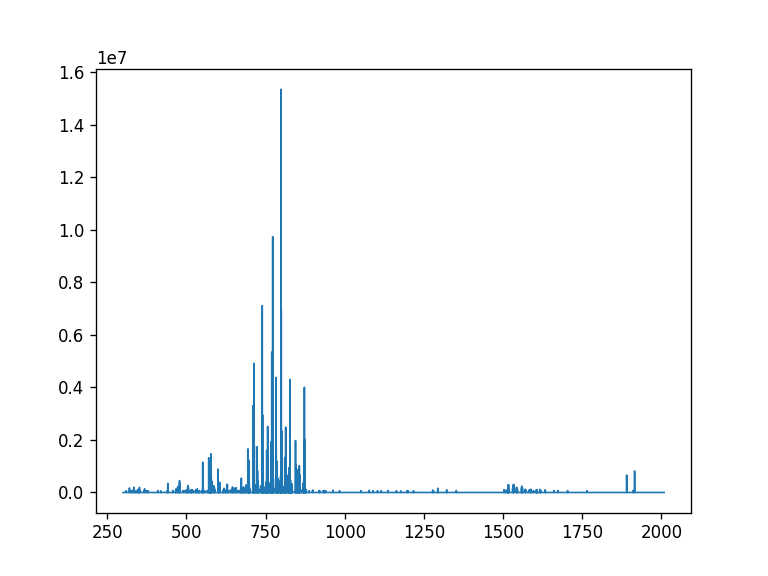

In [22]:
plt.figure()
S.plot(profile=True)

<IPython.core.display.Javascript object>


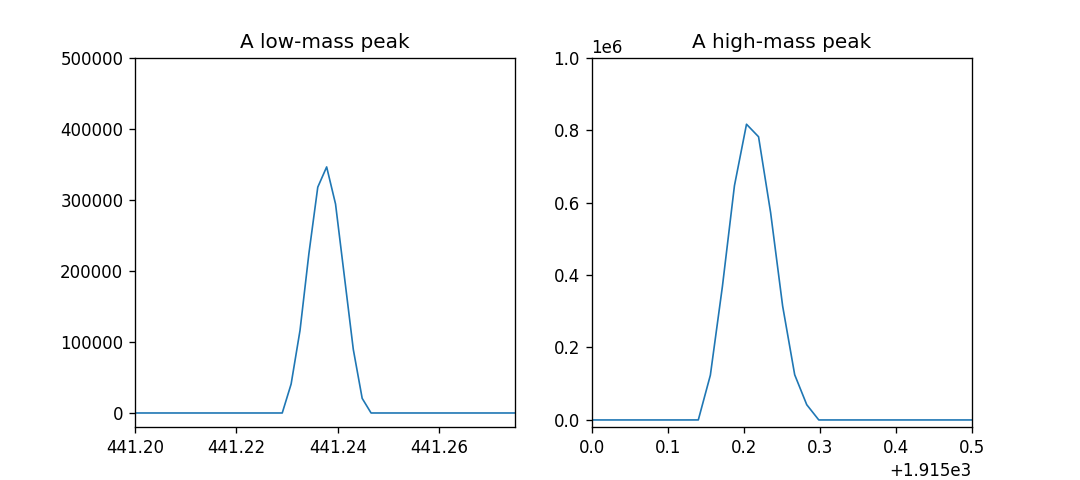

In [23]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title('A low-mass peak')
plt.xlim(441.2, 441.275)
plt.ylim(-2e4, 5e5)
S.plot(profile=True, show=False)
plt.subplot(122)
plt.title('A high-mass peak')
plt.xlim(1915, 1915.5)
plt.ylim(-2e4, 1e6)
S.plot(profile=True, show=False)

The width of the low-mass peak at 441.23 Da is equal to 441.248 - 441.228 = 0.02, and the width of the high-mass peak at 1915.21 Da is equal to 1915.30 - 1915.14 = 0.16. The mz values of peak boundaries can be checked by moving the mouse cursor at them and checking the x coordinate displayed in the lower-right part of the plot.

To get the peak width at any mz value, denoted x, we use a linear interpolation of the two manually computed widths:  
$w(x) = 0.02 + (0.16-0.02)(x-441.23)/(1915.30 - 441.23)$.

**Exercise:** Use the above function to estimate the peak width at 334.08 Da. Compare your result with the actual width of this peak.  

We want an approximately constant number of mz measurements per peak, say $n$. Therefore, for a peak at mz value $x$ we want to get $n$ mz points distributed over $w(x)$. We will get approximately this number if the spacing between two consecutive mz points near $x$ will be equal to $w(x)/n$.   
Based on this argument, we proceed as follows: We fix the number $n$, say $n=4$, and the initial mz value $m_0$, say $m_0 = 400$ Da (we can discard the low-mass fragment of the spectrum, because it won't be interesting for us).  
Then, given a point $m_i$, we compute the next point $m_{i+1}$ as $m_{i+1} = m_i + w(m_i)/n$.  
We repeat this procedure until we hit a pre-defined mass $m_{max}$, say $m_{max} = 900$ Da.  

In [24]:
def w(x): return 0.02 + (0.16-0.02)*(x-441.23)/(1915.30 - 441.23)

In [25]:
n = 14  # the more, the better; original spectrum has around n=16 points per peak
common_mass_axis = [400]
while common_mass_axis[-1] < 900:
    last_mass = common_mass_axis[-1]
    common_mass_axis.append(last_mass + w(last_mass)/n)

In [26]:
print('The common mass axis has', len(common_mass_axis), 'points.')

The common mass axis has 202589 points.


We need to check if this mass axis gives a good resampling.  
We'll do that on a single spectrum.

In [27]:
X,Y = 40, 20
spectrum_id = image.coordinates.index((X, Y, 1))
mz, intensity = image.getspectrum(spectrum_id)
mz = np.array(mz)
intensity = np.array(intensity)

In [28]:
new_intensity = resample(common_mass_axis, mz, intensity)

<IPython.core.display.Javascript object>


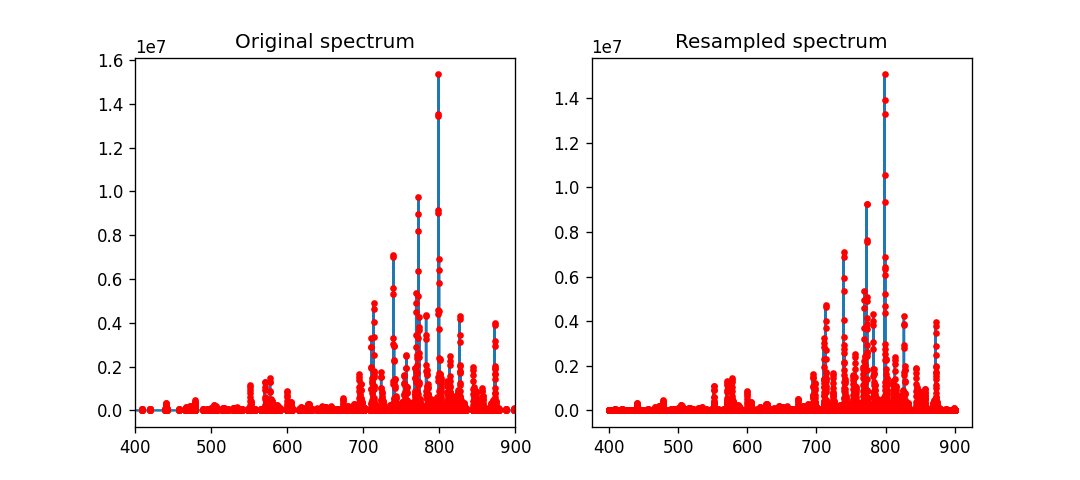

In [29]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title('Original spectrum')
plt.xlim(400, 900)
plt.plot(mz, intensity)
plt.plot(mz, intensity, 'r.')
plt.subplot(122)
plt.title('Resampled spectrum')
plt.plot(common_mass_axis, new_intensity)
plt.plot(common_mass_axis, new_intensity, 'r.')
plt.show()

**Exercise:** What are the drawbacks of too large and too small $n$ values?

We will now compute the average spectrum of the image.  
We iterate through the pixels, get the spectrum for each pixel, resample it using the common mass axis, and add the resulting intensity to the average intensity vector. Finally, we divide the summed intensity by the number of pixels.

First, create a vector to store summed signal intensities.  
We'll also create a vector to store the maximum intensity at each mz (a so-called *skyline spectrum*) and the minimum intensity.  
The initial vector of minimum intensities needs to be higher than the intensities of the spectra. We'll set it as 1e10.

In [30]:
average_intensity = np.zeros(len(common_mass_axis))  
max_intensity = np.zeros(len(common_mass_axis))
min_intensity = np.ones(len(common_mass_axis))*1e10  

In [31]:
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    mz,intsy =  image.getspectrum(idx)
    mz = np.array(mz)
    intsy = np.array(intsy)
    
    resampled_intensity = resample(common_mass_axis, mz, intsy)
    average_intensity += resampled_intensity
    max_intensity = np.maximum(max_intensity, resampled_intensity)
    min_intensity = np.minimum(min_intensity, resampled_intensity)

To normalize the `average_intensity` array, we use the fact that the length of the previously computed variable `TIC_array` is equal to the number of pixels.

In [32]:
average_intensity /= len(TIC_array)

To get the standard deviation of signal at each mz, we iterate over the pixels the second time and compute the squared differences between the observed and the average signal. In each mz we then take the average of those differences and the square root of the average.

In [33]:
intensity_std = np.zeros(len(common_mass_axis))

In [34]:
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    mz,intsy =  image.getspectrum(idx)
    mz = np.array(mz)
    intsy = np.array(intsy)
    
    resampled_intensity = resample(common_mass_axis, mz, intsy)
    intensity_std += (resampled_intensity - average_intensity)**2

In [35]:
intensity_std /= len(TIC_array)
intensity_std = np.sqrt(intensity_std)

Now, we can create the *summary spectrum* of the image.  
We'll show the average signal $\mu$ with a blue line, the region of $\mu \pm \sigma$ with a dark orange ribbon, and the region of $\mu \pm 3\sigma$ with a light orange ribbon. The maximum and minimum signals will be shown with grey lines.  

Note that, under the assumption of a normal distribution of signal intensity at each mz, for 99% of the pixels the signal intensity lies within the interval $[\mu(mz) - 3\sigma(mz), \mu(mz) + 3\sigma(mz)]$, hence the light orange ribbon. The assumption of a normal distribution is obviously not satisfied for many signals (for example because they may be absent in some pixels but present in others, so the value of 0 occurs multiple times), but the $3\sigma$ rule is still a valuable rule of thumb. 

<IPython.core.display.Javascript object>


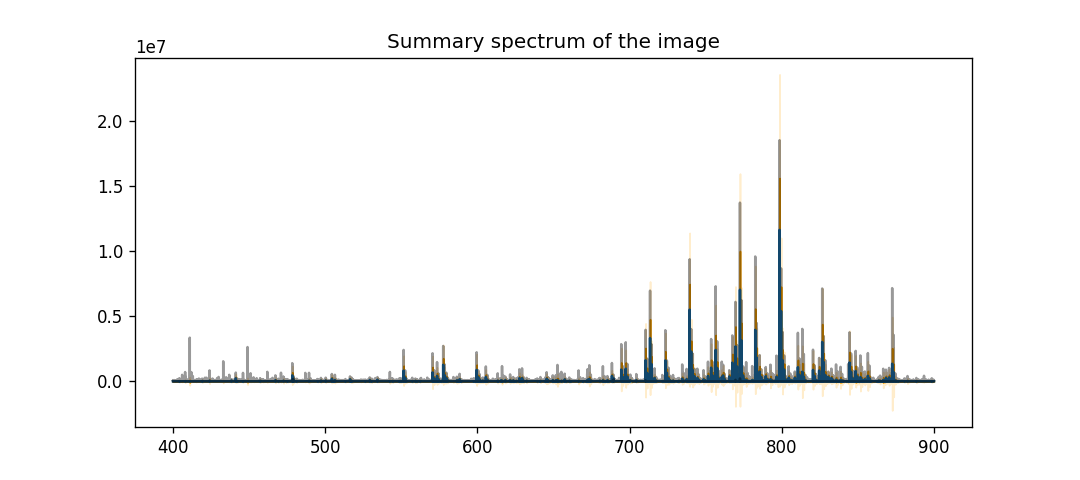

In [36]:
plt.figure(figsize=(9, 4))
plt.title('Summary spectrum of the image')
plt.fill_between(common_mass_axis, average_intensity-intensity_std, average_intensity+intensity_std, alpha=1, color='orange')
plt.fill_between(common_mass_axis, average_intensity-3*intensity_std, average_intensity+3*intensity_std, alpha=0.2, color='orange')
plt.plot(common_mass_axis, average_intensity)
plt.plot(common_mass_axis, max_intensity, 'k', alpha=0.4)
plt.plot(common_mass_axis, min_intensity, 'k', alpha=0.4)
plt.show()

How to read a summary spectrum (use the interactive plot to zoom in regions described below):   
    - Zooming on the region 798.4 - 798.7 shows us that there is a peak at 798.55 that has a fairly similar intensity in many pixels. The maximum intensity is close to the $\mu \pm \sigma$ ribbon, which indicates that there are no outlying observations (sometimes we have improper measurements and in some pixels the intensity is extremely high). On the other hand, this shows us that this peak is rather uniformly distributed over all pixels, so it won't be useful in detecting different tissues. The minimum intensity is zero, indicating that this peak is absent in some spectra (most likely the background ones, where there's no tissue sample). 
    - Zooming on the region 627.3 - 627.9 shows us a peak at 627.55. Here the maximum intensity is much higher than the dark orange ribbon. This may indicate either outlying measurement, or the fact that this peak has a non-uniform distribution over different regions of the image (it's high in some pixels, but small or absent in many other pixels). Around this peak we see a random grey line, but the blue line is close to zero - this indicates background noise (random non-zero intensity values). Since the orange ribbons are very small, the noise occurs rarely and randomly over the mz axis. At 627.3 we see a very small peak with a considerable standard deviation - this means that this peak is present in some pixels, but it may be undetectable because it's height is similar to the noise level. 
    - At 410.98 we see a grey peak. This may indicate an outlying measurement (i.e. a randomly occuring measurement of high intensity), but this is unlikely because we can see an orange ribbon - this means that the number of pixels with a non-zero intensity measurement is sufficiently high to yield a noticeable standard deviation. Therefore, this is most likely some compound that occurs in a very small region of the tissue. This is further confirmed by the fact that we see peaks at 412 and 413 - so this is a correct isotopic envelope. 
    - At 699.5 - 702.5 we see a very strange phenomenon - a large region with non-zero intensity. This indicates that either the resampling was incorrect in this region, or that the detector of this mass spectrometer doesn't work properly for this mass. We see a peak at 700.454, but since this peak is within the strange region we shouldn't use it in our analyses. 
    - At 693.10 we see a grey peak that is most likely an outlying observation - the average intensity is very close to zero and the orange ribbon is rather tight around it, so the high intensity value indicated by the grey line is found only in a few pixels and could have occured due to random effects. 

**Exercise:** Use the summary spectrum to interpret the peak at 872.5 Da. Compare your interpretation with the ion image generated before. 

### Centroiding the spectra 

Up to this point we were working on spectra in *profile mode*, where the signal is a continuous curve.  
A *centroided spectrum* is a spectrum where each peak is represented by a single mass (usually the center of mass of a profile peak) and intensity (either the intensity of the apex of the peak or the area of the peak).    
Centroiding simplifies the analysis of spectra and speeds up many computations. 

First, we'll centroid a single spectrum and compare the result.

In [37]:
X,Y = 40, 20
spectrum_id = image.coordinates.index((X, Y, 1))
mz, intensity = image.getspectrum(spectrum_id)
mz = np.array(mz)
intensity = np.array(intensity)

In [38]:
S = Spectrum(confs=list(zip(mz, intensity)))

We'll use the `Spectrum.centroid` function from the `masserstein` package, which detects peaks and integrates their area in a region defined by a fraction of the apex intensity. By default, the function integrates the region defined by half of the maximum intensity of a profile peak. The lower the fraction, the larger the integration region and the more precise the results. However, at the same time there is a larger risk of integrating signals from other peaks or noise. For spectra with low amounts of noise, like this one, we may integrate the region defined by as low as 0.1 of the apex intensity to get accurate results.  

The documentation of this function can be accessed like this:

In [39]:
?S.centroid

To use the function, we need to supply it with the maximum width of the integration region. If a given peak is wider than that, it's treated as noise and discarded. We need to inspect the spectrum manually to see the peak widths.  

<IPython.core.display.Javascript object>


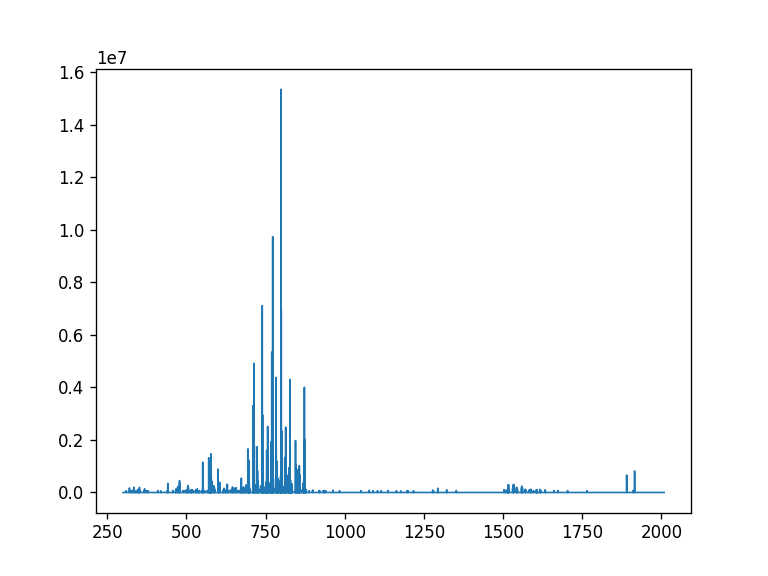

In [40]:
plt.figure()
S.plot(profile=True)

Looking at the peak at 872.564 Da, we see that its width at half maximum is 872.569 - 872.546 = 0.023 Da.  
We'll select a slightly larger value, 0.04, because otherwise we risk that many peaks will be discarded. 

In [41]:
peaks, apices = S.centroid(max_width=0.04, peak_height_fraction=0.5)
S_centroided = Spectrum(confs=peaks)

We can now compare the results and the original spectrum.

<IPython.core.display.Javascript object>


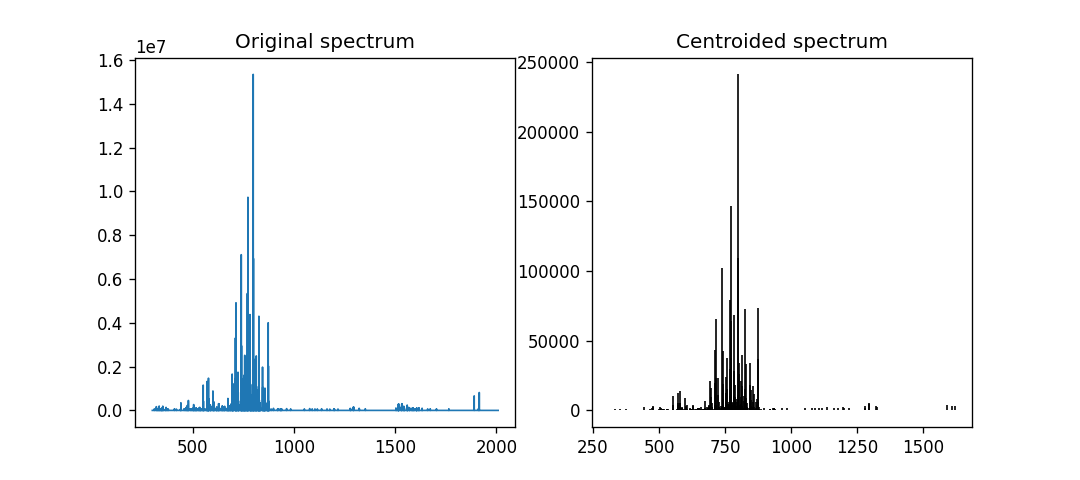

In [42]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title('Original spectrum')
S.plot(profile=True, show=False)
plt.subplot(122)
plt.title('Centroided spectrum')
S_centroided.plot(show=False)

We'll now centroid all the spectra and select the peaks that correspond to the ones that we've inspected in the summary spectrum to plot their ion images.  
We'll also plot an ion image of the peak at 872.5, that we've already plotted earlier, to compare the results.

In [43]:
target_peak_list = [872.5,   # ion image plotted before
                    798.55,  # uniform intensity
                    627.55,  # non-uniform intensity
                    627.3,   # similar to noise level
                    410.98,  # grey peak
                    693.10]  # another grey peak, likely outlier

Initialize an array to store the intensities:

In [44]:
target_intensities = np.zeros((len(TIC_array), len(target_peak_list)))  

In [45]:
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    mz,intsy =  image.getspectrum(idx)
    mz = np.array(mz)
    intsy = np.array(intsy)
    S = Spectrum(confs=list(zip(mz, intsy)))
    peaks, apices = S.centroid(max_width=0.04, peak_height_fraction=0.5)
    # We'll iterate over our target mz values and check if 
    # some of the peaks we've found in the spectrum is close
    for target_id, target_mz in enumerate(target_peak_list):
        peak_distances = [abs(mass - target_mz) for mass, intensity in peaks]
        if min(peak_distances) < 0.1:
            # this means we've found a peak that corresponds
            # to our target mz
            matching_peak_index = peak_distances.index(min(peak_distances))
            target_peak = peaks[matching_peak_index]  
            target_intensities[idx, target_id] = target_peak[1]

Now, let's make an ion image of a selected peak.  
We'll select a column of `target_intensities` and reshape it to match the image size.  
We'll use the `coords` variable that we've computed earlier to match the spectrum index (it's row number in the `target_intensities` array) with it's physical coordinates.

I'll select the first column and compare the result to the ion image that we've generated from the profile spectrum.

In [46]:
selected_ion = 0
selected_intensity = target_intensities[:,selected_ion]
ion_image = np.zeros((21, 81))
for intensity, crd in zip(selected_intensity, coords):
    ion_image[-(crd[1]-1), (crd[0]-1)] = intensity

<IPython.core.display.Javascript object>


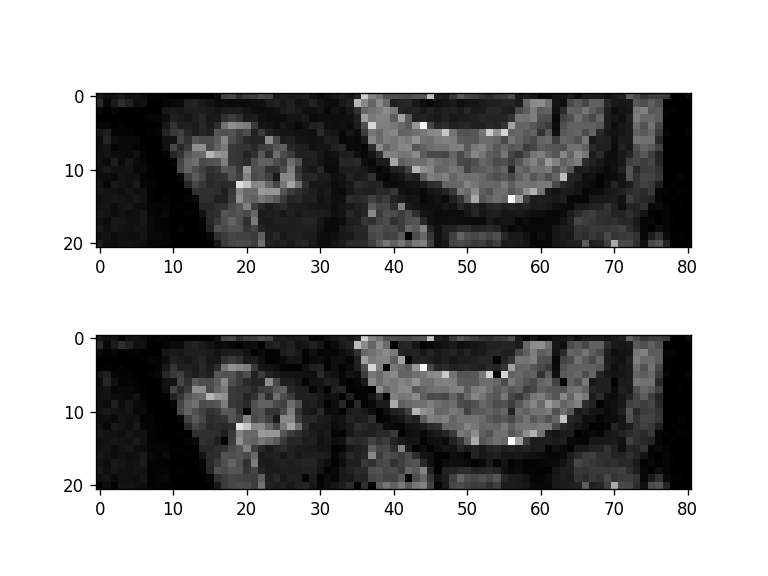

In [47]:
plt.figure()
plt.subplot(211)
plt.imshow(image_872_5, cmap=cm.gray)
plt.subplot(212)
plt.imshow(ion_image, cmap=cm.gray)
plt.show()

The results look similar, so it seems that centroiding worked properly.  
We can look at other ion images by modifying the `selected_ion` variable.

**Exercise:** Using spectra in profile mode, generate an ion image for the peak at 693.10 Da and compare it with the ion image we've generated from the centroided spectra.  
See what happens with the ion images if we centroid the spectra by integrating peaks within the region defined by 0.1 of the apex intensity, and then 0.9 of the apex intensity. Adjust the `max_width` parameter accordingly.  
See what happens if you strongly increase or decrease `max_width`.  

### Prinicipal Component Analysis of centroided spectra

Principal Component Analysis (PCA) allows us to segment the image by analyzing differences in peak intensities between pixels. We usually expect different segments to correspond to different tissues. Since PCA doesn't use any information about tissues except their peak intensities, the results need to be analyzed manually to check whether the obtained segments are actually meaningful. After that, loading plots can be used to characterize those segments and identify biomarkers, i.e. molecules that characterize different tissues.  

As an input, PCA requires a table with peak intensities. Therefore, we need to centroid all the spectra jointly, so that we get a common list of peaks and a matrix of their intensities in each pixel. There are several approaches to do this. We will centroid the average spectrum, select the highest peaks, and then resample the profile spectra from each pixel using the selected peak mz values.  

One thing should be noted here. There are two common approaches to centroiding: taking peak area or peak height (i.e. the apex intensity). However, the actual number of ions is proportional to the area of the corresponding peak. Since peaks in different parts of the spectrum have different widths, the number of ions is not directly proportional to their apex intensities. More formally, when all the peaks have the same shape (e.g. gaussian), the number of ions in a peak at mz $x$ is equal to $N(x) = cw(x)h(x)$, where $w(x)$ is the peak's width, $h(x)$ is the peak's height, and $c$ is a constant factor relating the area to the number of ions.   

Now, at each mz value $x$, PCA analyzes the variance of the signal intensity at $x$ between the pixels. Ideally, this variance should correspond to the variance of the number of ions. If we centroid the spectrum by selecting peak heights as their intensities, our signal intensities at two points $x_1 < x_2$ will be equal to $N(x_1)/w(x_1)$ and $N(x_2)/w(x_2)$. When $w(x_2) > w(x_1)$, as is the case in many (but not all!) mass spectrometers, the variance of the signal at $x_2$ will be much smaller than the variance of the number of ions. Therefore, PCA will pay less attention to the high-mass part of the spectrum, and will segment the image using the information from the low-mass region.  

Centroiding by peak area is, however, much more difficult when many spectra need to be centroided jointly (so that their peak locations are the same, as required by PCA). Therefore, we will centroid the spectra by taking peak heights, and use a simple, approximate correction for differing peak widths by scaling those intensities by the function `w(x)` defined earlier.  

First, we start by centroiding the average spectrum.  

In [48]:
AvS = Spectrum(confs = list(zip(common_mass_axis, average_intensity)))

In [49]:
all_peaks, all_apices = AvS.centroid(max_width=0.06, peak_height_fraction=0.1)

In [50]:
AvS_centroid = Spectrum(confs=all_peaks)

In order to validate the centroiding, we will overlay the profile spectrum with the centroided one.  
However, due to varying peak width, it's difficult to compare those two spectra without a small preprocessing.  
We will therefore rescale peak intensities of the centroided spectrum using the width function `w` defined before, so that they are proportional to profile peaks heights.  

In [51]:
AvS_rescaled = Spectrum(confs = [(m, i/w(m)) for m, i in all_peaks])

Now, we will additionally rescale `AvS_rescaled` by a constant factor, that is selected manually to obtain a good fit. After some trials and errors, it turned out that a factor of 2.6 gives good results.  

In [52]:
AvS_rescaled = AvS_rescaled*2.6

<IPython.core.display.Javascript object>


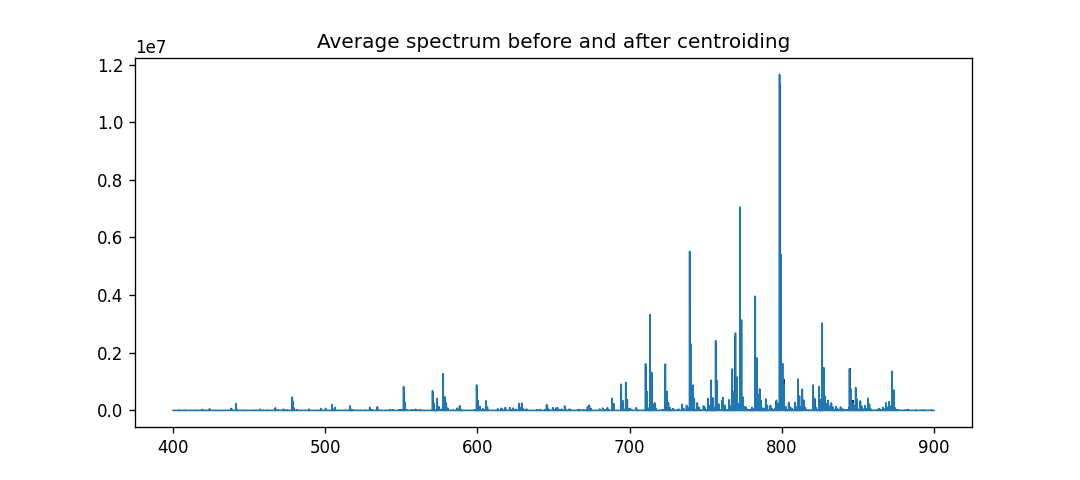

In [53]:
plt.figure(figsize=(9,4))
plt.title('Average spectrum before and after centroiding')
AvS.plot(profile=True, show=False)
AvS_rescaled.plot(show=False)  # rescaling the spectrum to match peak height
# plt.xlim(774.47, 774.65)
# plt.ylim(0, 0.5e06)

Inspecting a few selected peaks in low-, middle-, and high-mass region of the spectrum, we see that the rescaled centroided spectrum matches the profile spectrum with a good accuracy. This means that the parameters of the centroiding method should be good enough. This also confirms that the function `w(x)` gives a sufficiently close approximation of the peak width.   

**Exercise:** Compare the result after setting `peak_height_fraction` to 0.8 and adjusting `max_width` and the scaling factor accordingly. Pay an especially close attention to the peak cluster at 774.52 Da, a small peak at 472.5 Da, and inspect the accuracy at a few other selected peaks. What are the pros and cons of setting a high `peak_height_fraction` parameter?  

This way, we have obtained a large number of peaks. This may cause problems with the RAM memory when we create an array of peak intensities in all pixels, especially when analyzing large images with complex spectra. Also, small peaks may occur due to background noise, and can interfere with our PCA results. We will therefore discard them. First, we'll generate an empirical cumulative distribution function (ECDF) plot, to select an appropriate threshold of peak intensity.

In [54]:
print('Centroiding procedure detected', len(all_peaks), 'peaks in total')

Centroiding procedure detected 3302 peaks in total


In [55]:
all_intensities = sorted(x[1] for x in all_peaks)

In [56]:
ecdf = np.arange(1, len(all_intensities)+1, 1)/len(all_intensities)

<IPython.core.display.Javascript object>


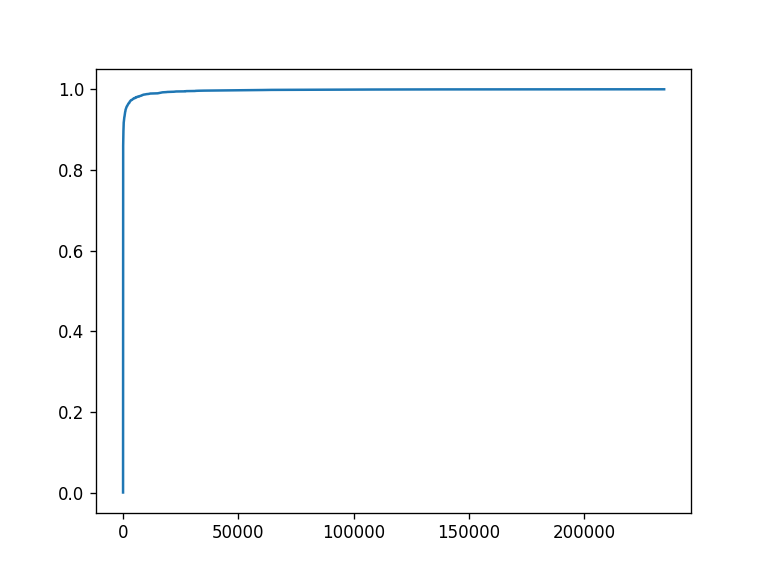

In [57]:
plt.figure()
plt.plot(all_intensities, ecdf)
plt.show()

We can see that 90% of intensities are below 180. Selecting this threshold will retain a large number of peaks, including low-intensity ones. Since the image and the total number of peaks are small, we will select this threshold in order not to lose too many interesting peaks. A more restrictive threshold candidate is 2500 - this would leave us with only the highest peaks.  

In [58]:
threshold = 180
selected_peaks = [p for p in all_peaks if p[1] >= threshold]
print('The intensity threshold equal %f selects %i peaks' % (threshold, len(selected_peaks)))

The intensity threshold equal 180.000000 selects 334 peaks


As a validation step, let's see what peaks were selected.

In [59]:
filtered_S = Spectrum(confs=selected_peaks)

<IPython.core.display.Javascript object>


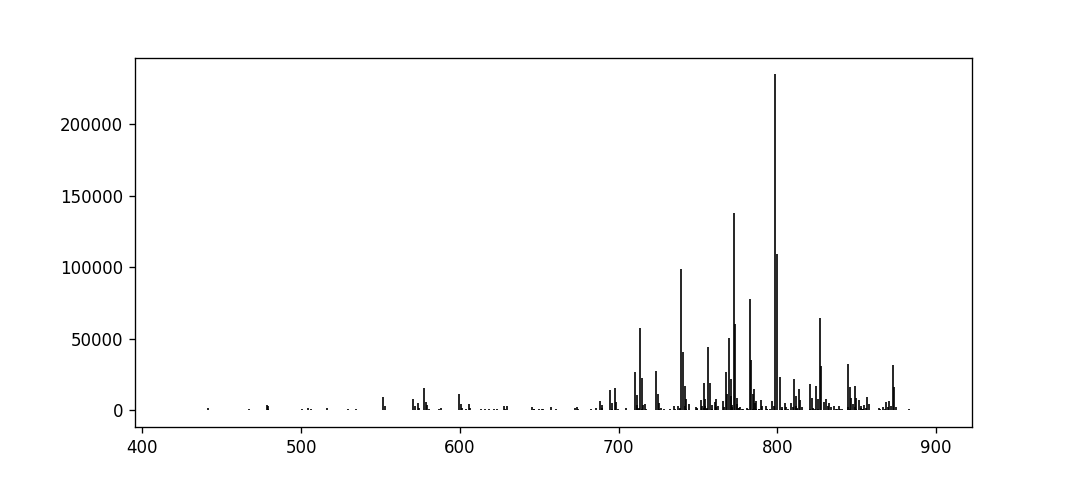

In [60]:
plt.figure(figsize=(9,4))
filtered_S.plot()

We can see that the spectrum constructed from the selected peaks still contains a lot of information.  
On the first glance, there is no difference between the filtered and the original spectrum. This is because most of the discarded peaks are too small to be visible in the original spectrum.  
A spectrum like this should allow for a meaningful PCA.  

We will now resample each pixel using the selected mz values in order to approximate the peak heights.

In [61]:
target_mz = np.array([p[0] for p in selected_peaks])

In [62]:
peak_heights = np.zeros((len(TIC_array), len(target_mz)))

In [63]:
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    mz,intsy =  image.getspectrum(idx)
    ph = resample(target_mz, mz, intsy)
    peak_heights[idx,:] = ph

Again, we should validate the results. We'll do that by plotting the ion image of the peak at 872.5 Da.  
First, we identify which of the centroided peaks match this signal. This time we'll do this using `numpy`.  

In [64]:
peak_872_5_id = (np.abs(target_mz - 872.5)).argmin()
peak_872_5_mz = target_mz[peak_872_5_id]
peak_872_5_mz

872.557955319796

The obtained value is close to 872.5 Da, so we can conclude that this is indeed the matching peak.  
Let's generate the ion image.  

<IPython.core.display.Javascript object>


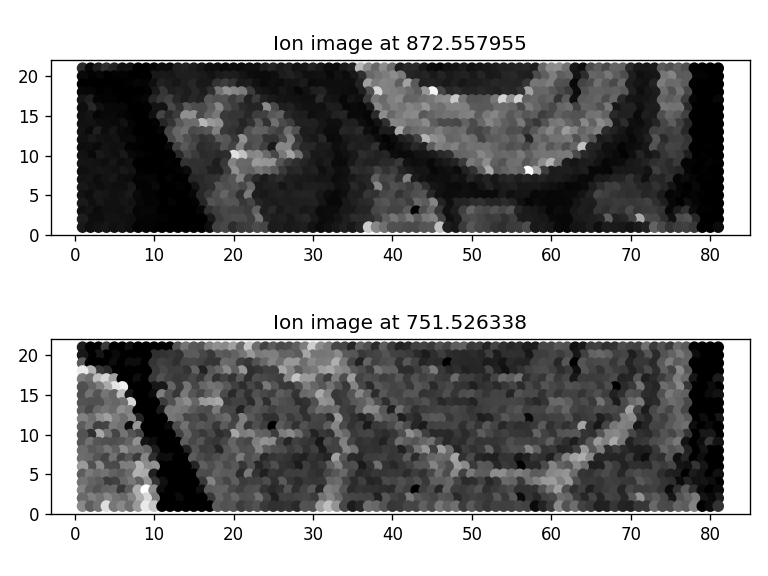

In [65]:
plt.figure()
plt.subplot(211)
plt.scatter(coords[:,0], coords[:,1], c=peak_heights[:,peak_872_5_id], cmap=cm.gray)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Ion image at %f' % target_mz[peak_872_5_id])
plt.subplot(212)
plt.title('Ion image at %f' % target_mz[peak_872_5_id//2])
plt.scatter(coords[:,0], coords[:,1], c=peak_heights[:,peak_872_5_id//2], cmap=cm.gray)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

The image agrees with the previous result.  
As an additional negative control, we have inspected another image and made sure that not all images look like this.  
We can proceed with rescaling the peak heights with our `w(x)` function to approximate peak areas. 

In [66]:
peak_widths = w(target_mz)

In [67]:
peak_areas = peak_heights*peak_widths

We can now use `peak_areas` to perform PCA with the `sklearn.decomposition.PCA()` function.

In [68]:
from sklearn.decomposition import PCA

In [69]:
peak_pca = PCA(n_components=6)
peak_pca_fit = peak_pca.fit_transform(peak_areas)

First, we inspect the ratio of variance explained by each component.  

In [70]:
print(peak_pca.explained_variance_ratio_)

[0.72059596 0.13765425 0.05985733 0.0337795  0.01253712 0.00866046]


We see that the first component explains the majority of the variance in the data. This usually corresponds to delineating the sample from the background.  
The first five components explain 96% of the variance, so the rest of the components is probably not meaningful.

Let's now create the scoring plots (or scoring images), i.e. images in which each pixel is colored by its score in the given principal component.  

<IPython.core.display.Javascript object>


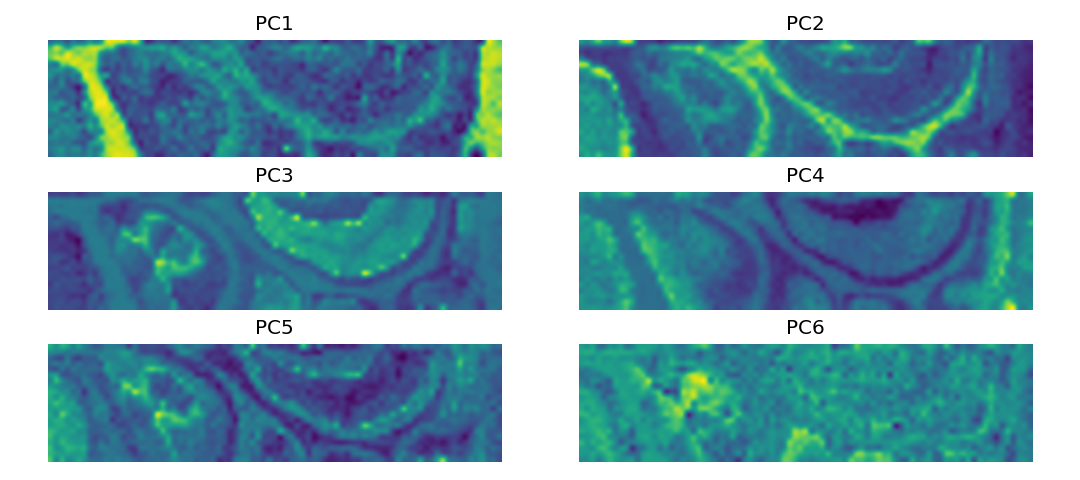

In [71]:
plt.figure(figsize=(9, 4))
for i in range(6):
    plt.subplot(3, 2, 1 + i)
    plt.title('PC%i' % (i+1))
    plt.axis('off')
    score_matrix = np.zeros((21, 81))
    for crd, intensity in zip(coords, peak_pca_fit[:,i]):
            crd = crd-1
            score_matrix[-crd[1], crd[0]] = intensity
    plt.imshow(score_matrix, interpolation='mitchell')
plt.tight_layout()

How to interpret scoring plots: Each principal component allows to segment the image into two regions, defined by its positive and negative score.  
Each image shows a pair of regions (yellow and blue) that correspond to the positive and the negative scores of a given principal component.  

The segmentation shown above can be interpreted in terms of the anatomy of a mouse cerebellum.  
For reference, an example diagram of a mouse cerebellum can be seen in Figure 1 [here](https://www.researchgate.net/publication/256501483_Congenital_hypoplasia_of_the_cerebellum_Developmental_causes_and_behavioral_consequences).

In the scoring image above, PC1 separates the *granular* and *molecular layers* of the cerebellum (blue) from the *white matter* and the background (yellow).  
PC2 separates the white matter (yellow) from the other regions, especially the molecular layer (yellow).  
PC3 separates the granular layer (blue) from the molecular layer (yellow), while PC4 separates the granular layer (blue) from an unidentified region around the background (yellow).  
PC5 separates the Purkinje cell layer (thin yellow strip around the molecular layer) from the molecular layer and white matter (blue).

To inspect which peaks contribute to the segmentation discussed above, we inspect the loading plots (spectra) of the principal components.

<IPython.core.display.Javascript object>


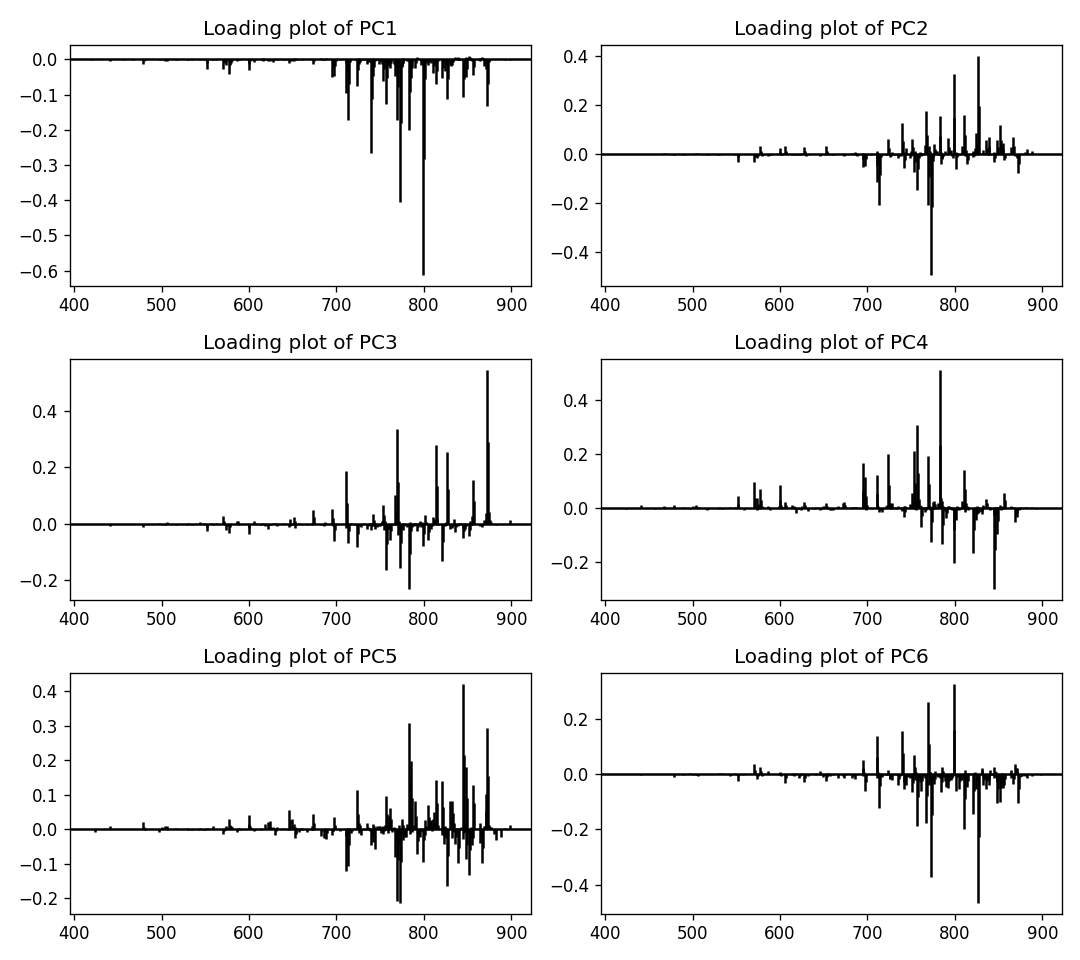

In [72]:
plt.figure(figsize=(9,8))
for i in range(6):
    plt.subplot(321+i)
    plt.vlines(target_mz, [0]*len(target_mz), peak_pca.components_[i])
    plt.title('Loading plot of PC%i' % (i+1))
    plt.axhline(c='black')
plt.tight_layout()

W can see that there is virtually no visible positive signal in PC1, all the major peaks are on the negative side of this plot. This means that this component is negative whenever a given pixel contains a high-intensity signal, confirming that PC1+ corresponds to the background and PC1+ to the sample.  
The positive part of PC2, i.e. PC2+, corresponds to the white matter. Therefore, we can inspect the loading spectrum to see what peaks are characteristic for the white matter. Two major signals in the positive part of the PC2 loading plot are at 827.56 Da and 798.54 Da.  

We can now use tools from the LIPID MAPS database to check which lipids have similar masses (an appropriate tool can be found at https://www.lipidmaps.org/ -> Resources -> Tools -> Multiple lipid classes). Two likely candidates are TG(48:9) + K for 827.56 Da and PC(34:1) + K for 798.54 Da. Many lipids, however, share their molecular formula (e.g. PC(34:1) and PE(37:1)), so without MS2 spectra we cannot conclude the actual structure of the lipid.   

In conclusion, if our guess is correct (note that there are other lipids with different molecular formulas, but similar masses), we conclude that the white matter is enriched in lipids with a molecular formula $C_{42}H_{82}NO_{8}PK$ and $C_{51}H_{80}O_6K$. Naturally, in an actual scientific study, further experiments would be required to confirm this guess.  

**Exercise:** Perform the PCA on peak heights instead of approximated peak areas and compare the loading plots. Notice that in the loading plots generated from peak height data, the peaks in low-mass regions tend to be higher (in terms of their distance from the zero line) than for the peak area data. This reflects the fact discussed before, that PCA performed on peak heights will put more emphasis on the low-mass region of the spectrum. The higher the peak in a loading plot, the higher its contribution to the score of a given pixel. Also, notice that PC6 gets inverted when peak heights are used; an invertion of a principal component doesn't change its interpretation, but care needs to be taken not to mix up the positive and negative parts of the loading and the scoring plots.

On this dataset, PCA performed on peak heights gives very similar scorings of principal components, because the spectra contain a clear information (there are large differences between tissue compositions and not many noise peaks) and the range of mz values is rather small, so peak widths do not differ much. More pronounced differences can be seen in case of data with similar tissues, noisy spectra and larger mz ranges. 

### Regression of experimental spectra against theoretical ones

Regression means estimating the proportion of signal corresponding to a given theoretical spectrum.  
Typically, we have a molecular formula of an ion of interest and we ask how much of this ion is in each pixel.  
This is similar to generating ion images, only instead of a single peak we use a whole isotopic envelope of an ion. This makes the procedure more robust to interfering signals, such as the background noise.  
To perform regression of spectra, we'll use the `masserstein.estimate_proportions` function.  

First, we need to select ions of interest. I've chosen three phospholipids: PC(32:0), PC(34:1) and PA(34:1), with molecular formulas $C_{40}H_{80}NO_{8}P$, $C_{42}H_{82}NO_{8}P$ and $C_{37}H_{71}O_{8}P$. More information about these lipids (including their chemical structures) can be found in the LIPID MAPS database, see e.g. https://www.lipidmaps.org/data/LMSDRecord.php?LMID=LMGP10010724.  

Second, we need to generate their theoretical spectra. To do this, we'll use the `masserstein` package. We'll assume that the ions are charged with potassium adducts. The `threshold` argument controls the height of the lowest of the simulated peaks - peaks lower than this are discarded. This is an important parameter, because small peaks are very variable in the experimental spectra. Fitting theoretical envelopes to small peaks greatly decreases the accuracy of the method. On the other hand, when this threshold is set too high, the theoretical spectra contain a very small number of peaks. This also decreases the accuracy of the estimation.    The amount of information in the theoretical spectrum always needs to be adjusted to the experimental spectrum.  
When analyzing spectra with a high amount of noise or a low amount of signal, it is often a good practice to additionally discard heavy peaks (i.e. select only the first two or three peaks from the theoretical isotopic envelope).  

In [73]:
PC32_0 = Spectrum(formula='C40H80NO8P', adduct='K', threshold=0.01)
PC34_1 = Spectrum(formula='C42H82NO8P', adduct='K', threshold=0.01)
PA34_1 = Spectrum(formula='C37H71O8P', adduct='K', threshold=0.01)

In [74]:
query = [PC32_0, PC34_1, PA34_1]
query_names = ['PC(32:0)', 'PC(34:1)', 'PA(34:1)']

We'll check the spectra by plotting them.

<IPython.core.display.Javascript object>


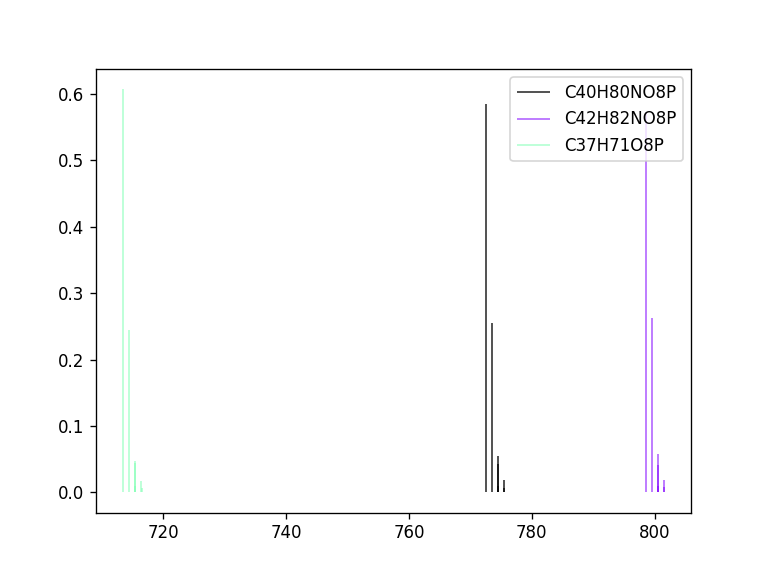

In [75]:
plt.figure()
Spectrum.plot_all(query)
plt.show()

We can proceed to the regression.  
We'll start by regressing the average spectrum. This will allow us to tune the parameters of our method.  
We'll use the peak-picked (i.e. centroided) spectrum after filtering of low-intensity peaks.

In [76]:
from masserstein import estimate_proportions

First, we need to normalize the experimental and theoretical spectra. 

In [77]:
filtered_S.normalize()
for S in query:
    S.normalize()

We will now use the function `estimate_proportions` from the `masserstein` package.  
The function requires to specify a single parameter, `MTD`, referred to as the *denoising penalty* or the $\kappa$ value.  
This parameter tells the function the expected maximum difference between the mz of an experimental peak and its theoretical counterpart. Typically, theoretical and experimental peak locations differ slightly due to measurement errors and centroiding inaccuracies. We need to account for those differences by setting an appropriate value of the MTD parameter. Usually, this value needs to be adjusted manually by trial and error. A good starting point is the profile peak width (assuming that the spectrum is properly calibrated). Values larger than 1 are not advised.  
For a detailed discussion of the $\kappa$ parameter, see the [Masserstein paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/rcm.8956).

For an initial fit, we will select $\kappa = 0.1$.  
At this stage, a precise selection of this value is not essential, because we'll start with very basic diagnostics of the model.  

In [78]:
regression_results = estimate_proportions(filtered_S, query, MTD=0.1)

The function `estimate_proportions` returns a dictionary with two fields: 'proportions' and 'noise'. The latter contains the experimental intensities that are left unexplained after the regression (an analogue of the $\varepsilon$ regression errors in an ordinary least squares regression).  

In [79]:
proportions = np.array(regression_results['proportions'])
noise = np.array(regression_results['noise'])

In [80]:
for S, p in zip(query, proportions):
    print('Proportion of', S.formula, 'is equal to', p)

Proportion of C40H80NO8P is equal to 0.05880105932036877
Proportion of C42H82NO8P is equal to 0.001112797528916399
Proportion of C37H71O8P is equal to 0.017816415568632855


We will now inspect the results on a plot showing the experimental spectrum overlayed with the fitted model and the remaining signal highlighted in red.  
We will also highlight the monoisotopic masses of the theoretical spectra in order to find them more easily.  

In [81]:
target_mz = np.array([x[0] for x in filtered_S.confs])
target_intensity = np.array([x[1] for x in filtered_S.confs])

<IPython.core.display.Javascript object>


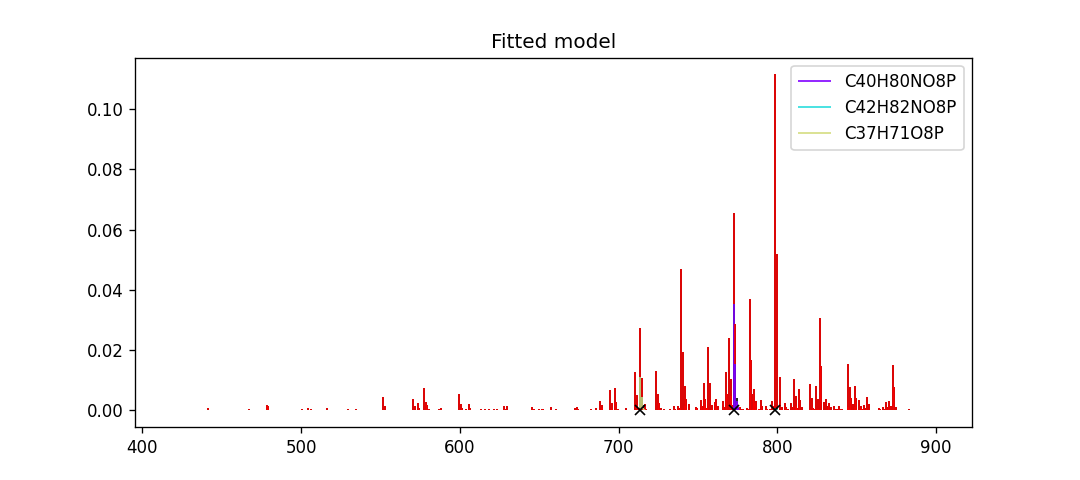

In [82]:
plt.figure(figsize=(9, 4))
plt.title('Fitted model')
Spectrum.plot_all([filtered_S] + [S*p for S, p in zip(query, proportions)], show=False, alpha=1)
plt.vlines(target_mz, target_intensity-noise, target_intensity, color='red', lw=1)
for S in query:
    plt.plot(S.confs[0][0], 0, 'kx')

Zooming in on the theoretical isotopic envelopes (regions of 713.5 Da, 772.5 Da and 798.5 Da), we can see that the proportions are underestimated. There are two possible reasons for an underestimation of proportion of a theoretical spectrum: a low $\kappa$ value and an overly detailed isotopic envelope. 

Inspecting the envelope at 798.5 Da, we see that we're dealing with the second case. The two theoretical peaks at 800.5 Da do not have an experimental counterpart. In the current implementation of `masserstein`, the lack of available signal for those peaks forces the proportion to be close to zero.  

Inspecting the spectrum at 713.5 Da, we see that it's underestimated because the third isotopic peak (at 715.5 Da) is lower than expected. This is often the case with heavy peaks (i.e. peaks corresponding to heavy isotopes) of small molecules. The intensity of such peaks is often under the *limit of quantification*. In simple terms, the limit of quantification is the lowest number of ions that gives a reliable measurement; it's usually higher than the limit of detection, which is the lowest number of ions that give a non-zero signal in the spectrum. When fitting theoretical isotopic envelopes with `masserstein`, it's crucial to discard those theoretical peaks which are expected be under the limit of quantification in the experimental spectrum.  

To adjust the information content of our theoretical spectra to the experimental one, we will discard peaks corresponding to isotopologues with more than one neutron. That is, we will retain the monoisotopic peak and the peaks which are 1 Da heavier.  

In [83]:
for S in query:
    monoisotopic_mass = S.confs[0][0]
    # we'll add an additional 0.2 Da as a safety margin,
    # because the first isotopic peak may be slightly further away than 1 Da
    S.confs = [p for p in S.confs if p[0] <= monoisotopic_mass + 1.2]  
    S.normalize()

<IPython.core.display.Javascript object>


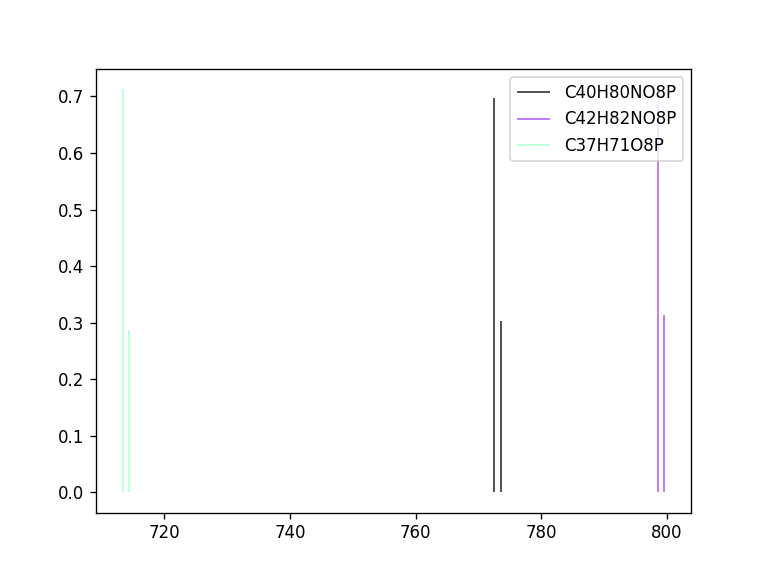

In [84]:
plt.figure()
Spectrum.plot_all(query)

Now, we fit the adjusted theoretical spectra again to check for other possible issues.  

In [85]:
regression_results = estimate_proportions(filtered_S, query, MTD=0.1)
proportions = np.array(regression_results['proportions'])
noise = np.array(regression_results['noise'])

In [86]:
for S, p in zip(query, proportions):
    print('Proportion of', S.formula, 'is equal to', p)

Proportion of C40H80NO8P is equal to 0.09397227416255975
Proportion of C42H82NO8P is equal to 0.16250610694295975
Proportion of C37H71O8P is equal to 0.038265256208565884


We see that the proportions have increased, as expected.  

<IPython.core.display.Javascript object>


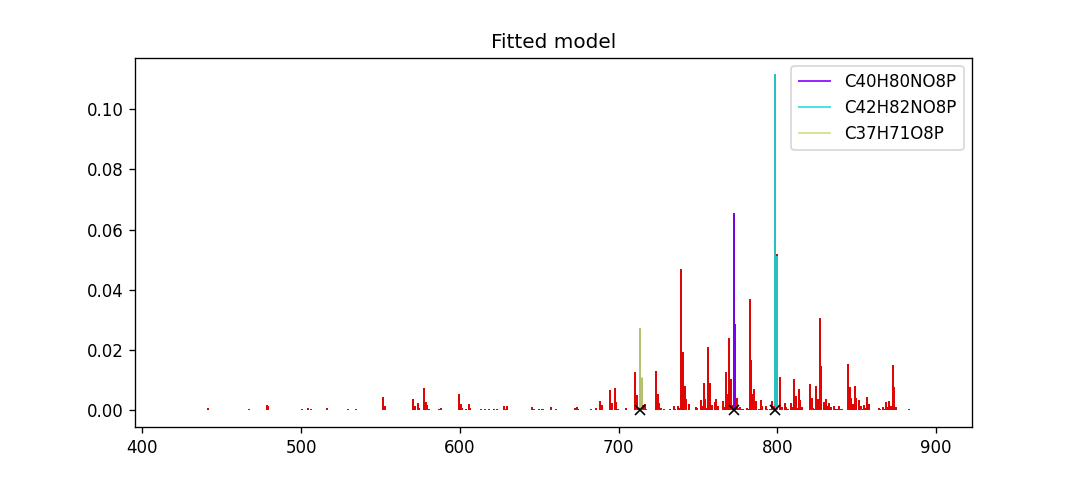

In [87]:
plt.figure(figsize=(9, 4))
plt.title('Fitted model')
Spectrum.plot_all([filtered_S] + [S*p for S, p in zip(query, proportions)], show=False, alpha=1)
plt.vlines(target_mz, target_intensity-noise, target_intensity, color='red', lw=1)
for S in query:
    plt.plot(S.confs[0][0], 0, 'kx')

Now the model fits much better. We can additionally adjust the $\kappa$ value. Large values may lead to overestimation of the proportions, because they allow noise signal to be incorporated in the estimates.  
We can see this around the peak at 714.45 Da: a small peak at 714.40 Da is partially black, indicating that some of its signal got transported to the theoretical spectrum.  
The intensity of this peak was used in the estimation of PA(34:1) (molecular formula C37H71O8P). 

Inspecting the plot above, we can see that the distance between the theoretical peaks and their experimental counterparts is very small, around 0.002 Da. A reasonable $\kappa$ value for this spectrum would be only slightly higher, say, 0.003 Da. We can confirm this by fitting the model again and inspecting the proportions:

In [88]:
regression_results = estimate_proportions(filtered_S, query, MTD=0.003)
proportions = np.array(regression_results['proportions'])
for S, p in zip(query, proportions):
    print('Proportion of', S.formula, 'is equal to', p)

Proportion of C40H80NO8P is equal to 0.09397227416255975
Proportion of C42H82NO8P is equal to 0.16250610694295975
Proportion of C37H71O8P is equal to 0.037208798278245955


The proportions are almost identical, except for PA(34:1), which is now slightly lower because the noise peak is no longer incorporated in the estimate.  

The $\kappa$ value 0.003 works well for the average spectrum. However, if we want to deconvolve individual spectra, we need to account for the fact that in some of them the distance between theoretical and experimental peaks may be slightly higher (an averaged spectrum tends to have a higher accuracy, because measurement errors from individual spectra cancel out). Therefore, to deconvolve all spectra, we will set $\kappa=0.01$. This value is safer, because we don't risk that peaks will not be matched, but at the same time it still doesn't lead to the incorporation of noise into PA(34:1).  

As for now, there are no rigorous studies on the proper selection of $\kappa$ parameter, so unfortunately we need to rely on such rules of thumb.

We will now proceed with analysis of the whole image.  
We will iterate over all pixels, get a corresponding spectrum, centroid it and regress against the theoretical spectra.   

In [89]:
lipid_proportions = np.zeros((len(TIC_array), len(query)))

In [90]:
for idx, (xcoord,ycoord,zcoord) in enumerate(image.coordinates):
    mz,intsy =  image.getspectrum(idx)
    mz = np.array(mz)
    intsy = np.array(intsy)
    S = Spectrum(confs=list(zip(mz, intsy)))
    peaks, apices = S.centroid(max_width=0.06, peak_height_fraction=0.1)
    S = Spectrum(confs = peaks)
    S.normalize()
    regression_results = estimate_proportions(S, query, MTD=0.01)
    lipid_proportions[idx,:] = regression_results['proportions']

After regression, we can visualize the results on ion images.  

<IPython.core.display.Javascript object>


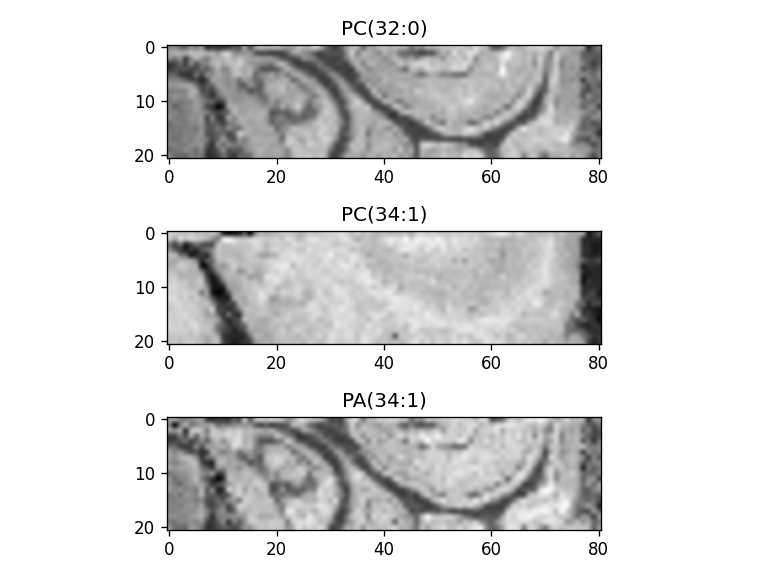

In [91]:
plt.figure()
for i in range(len(query)):
    plt.subplot(311 + i)
    intensity_matrix = np.zeros((21, 81))
    for idx, crd in enumerate(coords):
        intensity_matrix[-(crd[1]-1), crd[0]-1] = lipid_proportions[idx, i]
    plt.title(query_names[i])
    plt.imshow(intensity_matrix, cmap=cm.gray, interpolation='mitchell')
plt.tight_layout()

We can see that PC(32:0) is colocated with PA(34:1), meaning that those lipids occur in the same tissues: the granular and the molecular layer, while both are absent in the white matter and the Purkinje cell layer. On the other hand, PC(34:1) is localized uniformly over the cerebellum, with slight enrichment in the molecular layer. 

**Exercise:** Generate ion images of PC(38:6), PC(40:6), and PC(36:1) with potassium adducts (molecular formulas can be found in LIPID MAPS).  
Compare the results after increasing or decreasing the denoising penalty $\kappa$ and the information content of the theoretical spectra (either through retaining heavy peaks or adjusting the threshold parameter).  
Show the estimated proportions of the three lipids on a single image, with proportion of PC(38:6) in red, proportion of PC(40:6) in green, and proportion of PC(36:1) in blue.  